In [1]:
from recon_lidar_error_stat import init, getData, np, mean_squared_error, datetime, plt
import recon_lidar_error_stat
import pickle
import warnings
warnings.filterwarnings("ignore")

In [2]:
recon_lidar_error_stat.init()

In [8]:
def transfer_model(from_site_abbr, to_site_abbr, from_date_time, to_date_time, shift=True, with_swe=False):
    test_feature, test_y = getData(to_site_abbr, to_date_time, shift=shift, with_swe=with_swe)
    rf_model_fn = "regression_models/" + from_site_abbr + "_" + from_date_time.strftime("%y_%m_%d") + "_"
    if shift:
        rf_model_fn = "regression_models/" + from_site_abbr + "_" + from_date_time.strftime("%y_%m_%d") + "_shift_"
    if with_swe:
        rf_model_fn += "swe_rf.p"
    else:
        rf_model_fn += "rf.p"
    rf_model = pickle.load(open(rf_model_fn, "rb"))
    rf_model.n_jobs=1
    predict_y = rf_model.predict(test_feature)
    return np.corrcoef(test_y, predict_y), np.sqrt(mean_squared_error(test_y, predict_y))

In [11]:
def transfer_model_temporal(site_abbr, with_swe=False):
    if site_abbr == "MB":
        site_date_time = recon_lidar_error_stat.merced_date_list
    else:
        site_date_time = recon_lidar_error_stat.tuolumne_date_list
    corr_mat = np.zeros((len(site_date_time), len(site_date_time)))
    rmse_mat = np.zeros((len(site_date_time), len(site_date_time)))
    for i, from_date_time in enumerate(site_date_time):
        for j, to_date_time in enumerate(site_date_time):
            corr, rmse = transfer_model(site_abbr, site_abbr, from_date_time, to_date_time, shift=True, with_swe=with_swe)
            corr_mat[i, j] = corr[0, 1]
            rmse_mat[i, j] = rmse
    plt.imshow(corr_mat, interpolation='nearest', cmap=plt.get_cmap("Oranges"), vmin=0.7, vmax=1.0)
    plt.colorbar()
    plt.show()
    plt.imshow(rmse_mat, interpolation='nearest', cmap=plt.get_cmap("Oranges"), vmin=0.05, vmax=0.2)
    plt.colorbar()
    plt.show()

Below is the figure showing of correlation and rmse of transfering the model to different dates when the feature __does not include__ the current reconstructed SWE

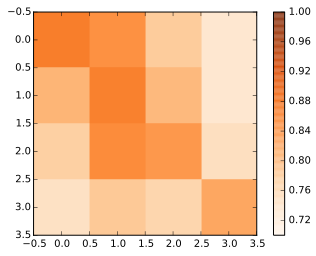

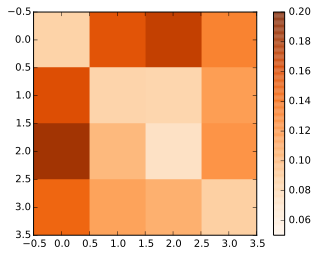

In [12]:
transfer_model_temporal("MB")

Below is the figure showing of correlation and rmse of transfering the model to different dates when the feature __include__ the current reconstructed SWE

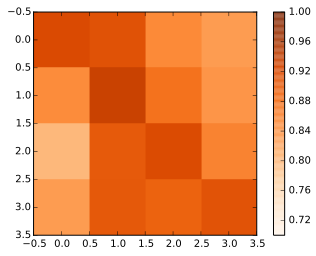

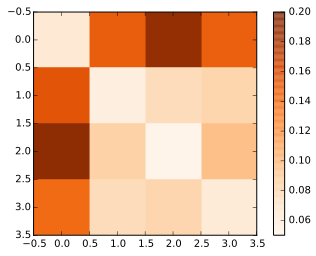

In [13]:
transfer_model_temporal("MB", with_swe=True)